In [65]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model,save_model
from keras.callbacks import ModelCheckpoint
from matplotlib.patches import Rectangle
import os
from scipy.misc import imsave
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import xception
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Input, Lambda
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.optimizers import Adadelta
from math import sqrt
from keras.callbacks import History 
import gc
from numpy.random import randint, choice
import numpy.random as rng
import keras.backend as K

In [66]:
from keras.preprocessing import image

def read_img(filepath, size):
    img = image.load_img((filepath), target_size=size)
    img = image.img_to_array(img,data_format='channels_last')
    return img

#### Data Processing


#### Dataset Details: 
The image dataset consists of good, blurry and flare image types with each type containing 25 images.  
I splitted the dataset into traning and validation sets, where the training data have 20 images and the validation data have 5 images of each type.



In [84]:
input_dim = (45,45,3)
imgSize=(45,45)

basePath = "C:/Users/akaur/Desktop/Data"
trainPath = os.path.join(basePath,'Train')
ValidationPath = os.path.join(basePath,'Validation')

#### Creating list of images

The Siamese network encodes the images into feature vectors. The Siamese network accepts the paired input.The paired input contains the list of positive pairs i.e. same kind of images and the negative pairs i.e. different images. The target value for the positive pairs is 1 and the negative pairs is 0. 

In [68]:
pairList = []
folderList = sorted(os.listdir(trainPath))


In [69]:
print(folderList)

['blurry-data', 'flare-data', 'good-data']


In [70]:
# Adding positive samples
for folder in folderList:
    imgList = os.listdir(os.path.join(trainPath,folder))
    for x in range(len(imgList)):
        for y in range(x, len(imgList)):
            img1 = read_img(os.path.join(trainPath,folder,imgList[x]) , imgSize)
            img2 = read_img(os.path.join(trainPath,folder,imgList[y]) , imgSize)
            pairList.append(((img1,img2),1))   

In [71]:
np.random.shuffle(pairList)
print(len(pairList))

517


In [73]:
for i in range(len(folderList)-1):
    for j in range(i,len(folderList)):
        folder1 = folderList[i]
        folder2 = folderList[j]
        if folder1!=folder2:
            imgList1 = os.listdir(os.path.join(trainPath,folder1))
            imgList2 = os.listdir(os.path.join(trainPath,folder2))
            for x in range(len(imgList1)):
                for y in range(len(imgList2)):
                    img1 = read_img(os.path.join(trainPath,folder1,imgList1[x]) , imgSize)
                    img2 = read_img(os.path.join(trainPath,folder2,imgList2[y]) , imgSize)
                    pairList.append(((img1,img2),0))
        
np.random.shuffle(pairList)

     

#### Display image

In [31]:
def display_image(folder1,img1,folder2,img2,train1=True,train2=True):
    
    
    if train1 == True:
        image1 = sorted(os.listdir(os.path.join(trainPath,folder1)))[img1]
        image1 = read_img(os.path.join(trainPath,folder1,image1), imgSize)
    else:
        image1 = sorted(os.listdir(os.path.join(ValidationPath,folder1)))[img1]
        image1 = read_img(os.path.join(ValidationPath,folder1,image1), imgSize)
        
    if train2 == True:
        image2 = sorted(os.listdir(os.path.join(trainPath,folder2)))[img2]
        image2 = read_img(os.path.join(trainPath,folder2,image2), imgSize)
    else:
        image2 = sorted(os.listdir(os.path.join(ValidationPath,folder2)))[img2]
        image2 = read_img(os.path.join(ValidationPath,folder2,image2), imgSize)
        
    plt.subplot(211)
    plt.imshow(image1)
    
    plt.subplot(212)
    plt.imshow(image2)
    

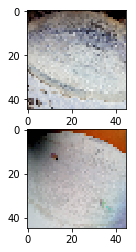

In [32]:
display_image('good-data',4,'flare-data',2,train1= True, train2= False)

#### Model Selection

Given the size of data set,  i used concept of one-shot learning i.e. Siamese Networks With CNN Base network. 

The major challenge with One-Shot Learning is the limited amount of data available to classify between numerous classes. Given the nature of the dataset, CNN was chosen since its the default neural network choice for working with images. However, given the need of basic CNNs for large amounts of data to work properly, we also look at a variant known as Siamese Networks i.e. Siamese Networks With CNN Base network. The dropout regularisation technique is used for reducing the overfitting in neural networks.

The contrastive loss function used in Siamese network tends to increase distance between the negative pairs and decreases the distance betwen the positive pairs. 



#### Defining functions for the model

In [75]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()

def W_init(shape,name=None):
    
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)


def b_init(shape,name=None):
    
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

#### Defining the model

In [76]:
baseModel = Sequential()
baseModel.add(BatchNormalization(input_shape = input_dim))
baseModel.add(Conv2D(64, (7,7),activation='relu', data_format='channels_last',kernel_initializer=W_init))
baseModel.add(MaxPooling2D())

baseModel.add(Dropout(0.3))
baseModel.add(Conv2D(128, (5,5),activation='relu',kernel_initializer=W_init, bias_initializer=izer=b_init))
baseModel.add(Dropout(0.3))
baseModel.add(Conv2D(256, (3,3),activation='relu',kernel_initializer=W_init, bias_initializer=b_init))
baseModel.add(Flatten())
baseModel.add(Dense(1028, activation='relu'))

inputA = Input(shape = input_dim)
inputB = Input(shape = input_dim)

outputA = baseModel(inputA)
outputB = baseModel(inputB)


#Extracting data
inputAimgs = np.array([x[0][0] for x in pairList])
inputBimgs = np.array([x[0][1] for x in pairList])
target = np.array([x[1] for x in pairList])

#### Loss functions used : 
Siamese Network uses Contrastive Loss as the loss function. I used Adadelta optimiser because of its adaptive learning rate.


### Siamese Net Model

In [77]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([outputA,outputB])

Siamese = Model(input=[inputA, inputB], output=distance)

Siamese.compile(Adadelta(lr=0.0001),loss=contrastive_loss)



C:\Users\akaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
Siamese.fit([inputAimgs,inputBimgs], target, batch_size = 30,epochs = 50)

#### Performance Metrics/Loss Functions
 Since the task involved is a classification one, I have used accuracy as the performance metric for the task. Since One-Shot learning focuses on the ability to classify a large number of classes based on lesser amounts of data, the accuracy is tested for different number of classes.
 
 I used the Validation Data to compute the accuracy of model.



## Validation Accuracy

In [79]:
def getSupportImgs(path):
    
    supportImg=[]
    
    os.chdir(path)
    folderList = os.listdir("./")
    
    for folder in folderList:
        os.chdir(os.path.join(path,folder))
        imgList = os.listdir("./")
        
        img = read_img(os.path.join(path,folder,choice(imgList)), imgSize)
        supportImg.append([img,folder])
        
    return(supportImg)
        

def predictBestFolder(img,label,trainPath,model,numImages =10,printList = False):
    
    predList = []
    
    folderList = sorted(os.listdir(trainPath))
    
    for folder in folderList:
        
        imgList = choice(os.listdir(os.path.join(trainPath,folder)), numImages, replace = False )
        folderPreds = []
        for i in range(numImages):
            folderImg = read_img(os.path.join(trainPath,folder,imgList[i]), imgSize )
            pred = model.predict([img.reshape(1,imgSize[0],imgSize[1],3), folderImg.reshape(1,imgSize[0],imgSize[1],3)])
            folderPreds.append(pred)
        
        predList.append([folder, np.mean(folderPreds)])
    
    predList = sorted(predList, key = lambda x:x[1])
    
    if printList == True:
        print(predList)
        
    return(predList[0])



#### Accuracy of Siamese model on Validation data

In [81]:
folderList = sorted( os.listdir(ValidationPath))
correctPred = 0
testImageCount = 0

for folder in folderList:
    os.chdir(os.path.join(ValidationPath,folder))
    imgList = os.listdir("./")
    
    for img in imgList:
        imgName = img
        testImageCount+=1
        
        img = read_img(os.path.join(ValidationPath,folder,img), imgSize)
        bestLabel = predictBestFolder(img,folder,trainPath,Siamese)[0]
        
        if bestLabel == folder:
            correctPred+=1
        acc = round(correctPred/float(testImageCount),3)
        print("Img : {} True Label : {}  Predicted Label : {} Accuracy : {}".format(imgName,folder,bestLabel,acc))
        
accuracy = correctPred/float(testImageCount)
print("Accuracy : {}".format(accuracy))


Img : 20170502T171526_G0094538.JPG True Label : blurry-data  Predicted Label : blurry-data Accuracy : 1.0
Img : 20170502T171758_G0107418.JPG True Label : blurry-data  Predicted Label : blurry-data Accuracy : 1.0
Img : 20170502T171806_G0094778.JPG True Label : blurry-data  Predicted Label : blurry-data Accuracy : 1.0
Img : 20170502T171813_G0094788.JPG True Label : blurry-data  Predicted Label : blurry-data Accuracy : 1.0
Img : 20170502T171838_G0107479.JPG True Label : blurry-data  Predicted Label : blurry-data Accuracy : 1.0
Img : 20170428T090330_G0015142.JPG True Label : flare-data  Predicted Label : blurry-data Accuracy : 0.833
Img : 20170428T090335_G0015150.JPG True Label : flare-data  Predicted Label : blurry-data Accuracy : 0.714
Img : 20170428T090338_G0015154.JPG True Label : flare-data  Predicted Label : blurry-data Accuracy : 0.625
Img : 20170428T090340_G0015157.JPG True Label : flare-data  Predicted Label : flare-data Accuracy : 0.667
Img : 20170427T135055_G0056423.JPG True Lab

In [83]:
save_model(Siamese,'./bestModel_0.81.hdf5')

In [87]:
baseModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 45, 45, 3)         12        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 39, 39, 64)        9472      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 128)       204928    
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 256)       295168    
__________

#### Results Of Validation Accuracy

The Validtaion Accuracy of Siamese model is 78 percent. The model is able to classify the good images, blurry images and flare images with overall accuracy of 78 percent.



